# Dall-E

## VQ-VAE

In [ ]:
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

In [1]:
from vqvae import *

In [2]:
# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [3]:
import jax
import jax.numpy as jnp

jax.local_device_count()

vqgan_model = VQGAN(VQGAN_REPO, VQGAN_COMMIT_ID)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
out = get_image("2.bmp")

In [5]:
np.array(out).shape

(64, 64, 3)

(1, 24, 24, 256) (1, 576)


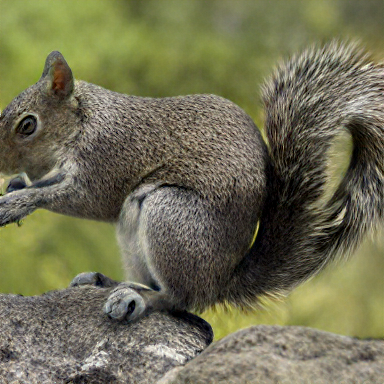

In [6]:
# Squirrel
quant_states, indices, rec = recon(
    url="https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1",
    vqgan_model=vqgan_model,
    size=384)
display(rec)

image: <PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=64x64 at 0x15430CEC8B0>
image.shape: (1, 64, 64, 3) [[[[0.41960785 0.49019608 0.34117648]
   [0.41568628 0.4862745  0.3372549 ]
   [0.42352942 0.49411765 0.34509805]
   ...
   [0.34509805 0.43529412 0.2627451 ]
   [0.3372549  0.42745098 0.25490198]
   [0.3254902  0.41568628 0.24313726]]

  [[0.4627451  0.53333336 0.38431373]
   [0.4509804  0.52156866 0.37254903]
   [0.45490196 0.5254902  0.3764706 ]
   ...
   [0.34117648 0.43137255 0.25882354]
   [0.32941177 0.41960785 0.25490198]
   [0.31764707 0.40784314 0.23529412]]

  [[0.46666667 0.5372549  0.3882353 ]
   [0.45490196 0.5254902  0.3764706 ]
   [0.4509804  0.52156866 0.37254903]
   ...
   [0.34117648 0.43137255 0.26666668]
   [0.33333334 0.41960785 0.26666668]
   [0.32156864 0.4117647  0.24705882]]

  ...

  [[0.21960784 0.22352941 0.19215687]
   [0.1764706  0.18039216 0.14901961]
   [0.11764706 0.12156863 0.09803922]
   ...
   [0.36862746 0.43529412 0.3019608 ]
   [0.34901

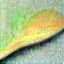

In [283]:
# Squirrel (Encode-Decode Full Code)
image = get_image("wooden spoon.bmp")
print("image:", image)
image = preprocess(image, 64)
print("image.shape:", image.shape, image)
quant_states, indices = vqgan_model.encode(image)
print("quant_states.shape, indices.shape:", quant_states.shape, indices.shape)
# rec                   = vqgan_model.decode(quant_states)
rec                   = vqgan_model.decode_code(indices)
print("rec.shape:", rec.shape, rec)
display(rec)

(1, 4, 4, 256) (1, 16)


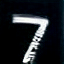

In [8]:
# MNIST Digit
quant_states, indices, rec = recon(
    url="sample_image.bmp",
    vqgan_model=vqgan_model,
    size=64)
display(rec)

(1, 4, 4, 256) (1, 16)


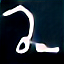

In [9]:
# Custom "2" Digit (MNIST Style)
quant_states, indices, rec = recon(
    url="2.bmp",
    vqgan_model=vqgan_model,
    size=64)
display(rec)

In [10]:
quant_states.shape, quant_states.dtype, indices.shape, indices.dtype, 

((1, 4, 4, 256), dtype('float32'), (1, 16), dtype('int32'))

In [11]:
indices

Array([[12025, 16248,  8222, 15433,  7491,   351, 12362, 15433,  3212,
         2601, 11712,  7580, 14164,  3927, 14247,  7721]], dtype=int32)

(1, 4, 4, 256) (1, 16)


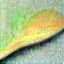

In [251]:
# Wooden spoon
quant_states, indices, rec = recon(
    url="wooden spoon.bmp",
    vqgan_model=vqgan_model,
    size=64)
display(rec)

## Dataset

In [520]:
CIFAR_CLASSES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [521]:
TINY_IMAGENET_BASE_DIR = "./data/tiny-imagenet-200/"

with open(TINY_IMAGENET_BASE_DIR + "wnids.txt") as f1:
    with open(TINY_IMAGENET_BASE_DIR + "words.txt") as f2:
        ids     = f1.read()
        words   = f2.read()
        ids_s   = ids.split("\n")
        ids_s.sort()
        words_s = {w.split("\t")[0]:w.split("\t")[1].split(",")[0] for w in words.split("\n")}
        TINY_IMAGENET_LABELS = [words_s[idx] for idx in ids_s]

In [522]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from tiny_imagenet import TinyImageNet


device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = "TINY_IMAGENET"
BS = 32

if DATASET == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BS, shuffle=True)
    train_image_zero, train_target_zero = trainset[0]

elif DATASET == "CIFAR10":
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transform = transforms.Compose([
        #transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        #transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        #transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(*stats, inplace=True)
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]
elif DATASET == "TINY_IMAGENET":
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    train_transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(), 
        #transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.ToTensor(),
        #transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(*stats, inplace=True)
    ])

    trainset = TinyImageNet(root='./data', split="train",  download=True, transform=train_transform)
    testset =  TinyImageNet(root='./data', split="val", download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        print([TINY_IMAGENET_LABELS[l] for l in labels])
        print(labels)
        break

# trainloader.to(device)
# testloader.to(device)

Files already downloaded and verified.
Files already downloaded and verified.


['tarantula', 'gasmask', 'bannister', 'magnetic compass', 'beacon', 'cannon', 'reel', 'ox', 'convertible', 'lion', 'Egyptian cat', 'bucket', 'jinrikisha', 'lemon', 'boa constrictor', 'chimpanzee', 'fly', 'academic gown', 'jinrikisha', 'snorkel', 'punching bag', 'cliff dwelling', 'candle', 'European fire salamander', 'lifeboat', 'cardigan', 'banana', 'candle', 'organ', 'sock', 'pop bottle', 'bikini']
tensor([  9, 106,  64, 117,  71,  84, 139,  49,  94,  34,  32,  80, 111, 187,
          5,  55,  37,  60, 111, 148, 138,  91,  83,   1, 115,  85, 188,  83,
        126, 149, 135,  74])


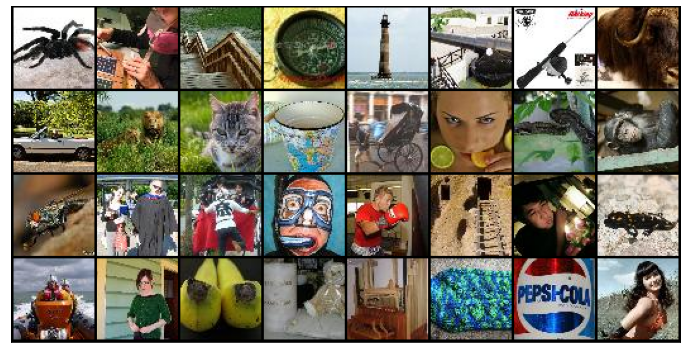

In [523]:
show_batch(trainloader)

## Model

In [524]:
def internal_preprocess(img, target_image_size=256, original_size=64):
    img *= 256
    img = img.numpy().astype(np.uint8)
    img = Image.fromarray(img)
    s = min(img.size)
    r = target_image_size / s
    s = (round(r * s), round(r * s))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

def text_encode(text, codebook_size=16384):
    return [ord(c) + codebook_size for c in text]

def text_decode(tokens, codebook_size=16384):
    return "".join([chr(t - codebook_size) for t in tokens])

def print_encoded(tokens):
    print(text_decode(tokens))

In [577]:
def multi_decode(seq_s):
    st = [256 + 16384 + t for t in [0, 1, 2, 3]]
    seq = list(seq_s[0])

    print("seq_s.shape, len(seq):", seq_s.shape, len(seq))
    # all special tokens in list
    if all(st_t in seq for st_t in st) and len(seq) >= 4 + 2:
        text_tokens  = torch.tensor(seq[seq.index(st[0])+1:seq.index(st[1])])
        image_tokens = torch.tensor(seq[seq.index(st[2])+1:seq.index(st[3])])
        #print(seq.index(st[0]), seq.index(st[1]), text_tokens.shape, image_tokens.shape)
        #print(seq.index(st[2]), seq.index(st[3]), text_tokens.shape, image_tokens.shape)
        print(text_tokens.shape, image_tokens.shape)
        text = text_decode(text_tokens)
        image_tokens = image_tokens.unsqueeze(0)
        image        = model.vqgan_model.decode_code(image_tokens)
        return text, image

    return None, None

In [526]:
"""
4 Special Tokens:
- [SOT] Start of Text
- [EOT] End of Text
- [SOI] Start of Image
- [EOI] End of Image
"""

import torch
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import megabyte

class DALLE(nn.Module):
    def __init__(
            self,
            vqgan_model,
            n_text_tokens=256,
            n_image_tokens=16384):
        super(DALLE, self).__init__()
        self.special_tokens   = ["SOT", "EOT", "SOI", "EOI"]
        self.vqgan_model = vqgan_model
        self.megabyte  = megabyte.MEGABYTE(
            heads      = 1,
            dim_head   = 16,
            num_tokens = n_text_tokens + n_image_tokens + len(self.special_tokens),
            dim        = (32, 32, 32), # (768, 256, 128)# Dg, Dl1, Dl2
            depth      = (1, 1, 1), # (6, 4, 2)
            max_seq_len = (16, 4, 4),
            flash_attn = False)
        self.n_text_tokens  = n_text_tokens
        self.n_image_tokens = n_image_tokens
        self.st = [self.n_text_tokens + self.n_image_tokens + self.special_tokens.index(t)
                   for t in self.special_tokens] # special token encodings
        
    def forward(self, x, debug=False, return_loss=True):
        x = self.megabyte(x, return_loss=return_loss)
        return x
    
    def get_params(self):
        o = [param.numel() for param in self.parameters() if param.requires_grad]
        o = sum(o)
        return o
    
    def text_encode(self, text):
        return [self.st[0]] + text_encode(text) + [self.st[1]]

    def image_encode(self, image, target_image_size, original_size):
        _, img_tokens  = vqgan_model.encode(
            internal_preprocess(image, target_image_size, original_size))
        return [self.st[2]] + img_tokens[0].tolist() + [self.st[3]]
    
    def multi_encode(self, text, image, target_image_size=64, original_size=32):
        txt_enc = self.text_encode(text)
        img_enc = self.image_encode(image, target_image_size, original_size)
        seq = torch.tensor(txt_enc + img_enc).to(device)
        seq = seq.unsqueeze(0)
        return seq

    def multi_decode(self, seq_s):
        st = [self.n_text_tokens + self.n_image_tokens + self.special_tokens.index(t)
              for t in self.special_tokens]
        seq = list(seq_s[0])

        # all special tokens in list
        if all(st_t in seq for st_t in st) and len(seq) >= len(self.special_tokens) + 2:
            text_tokens  = seq[seq.index(st[0] + 1):seq.index(st[1] - 1)]
            image_tokens = seq[seq.index(st[2] + 1):seq.index(st[3] - 1)]
            text = text_decode(text_tokens)
            image = self.vqgan_model.decode(image_tokens)
            return text, image

        return None

    def generate(self, *args):
        return self.megabyte.generate(*args)
    
def get_reserved_mem_gb():
    device = torch.cuda.current_device()
    reserved = torch.cuda.memory_reserved(device)
    reserved_gb = reserved / 1024 / 1024 / 1024
    return reserved_gb

## DALLE Tiny-ImageNet

### Train

In [593]:
model = DALLE(vqgan_model).to(device)

model.megabyte.get_num_params()

number of parameters: 2.21M


2209060

In [594]:
imgs, lbls = next(iter(trainloader))

In [595]:
imgs.shape, lbls.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [596]:
lbl = TINY_IMAGENET_LABELS[lbls[0]]
img = imgs[0].permute(1, 2, 0)

In [597]:
lbl, img.shape

('syringe', torch.Size([64, 64, 3]))

In [598]:
# test_inp = torch.randint(0, 1, size=(1, 16)).int().to(device)
test_inp = model.multi_encode(lbl, img, target_image_size=64, original_size=64)
print(test_inp.shape)
pred = model(test_inp.to(device), debug=True)
pred.shape, model.get_params()

torch.Size([1, 27])


(torch.Size([]), 2209060)

In [599]:
lbls[0]

tensor(159)

In [600]:
lbls

tensor([159,   3, 128,   2,  39, 158,   3,  65,  81, 151,  69,  99,  25, 161,
        153, 122,  34, 105, 179, 134, 144, 143,  66,  97, 119,  69,  77, 132,
         29,  94,  28, 144])

In [601]:
[TINY_IMAGENET_LABELS[lbl] for lbl in lbls]

['syringe',
 'tailed frog',
 'pay-phone',
 'bullfrog',
 'grasshopper',
 'swimming trunks',
 'tailed frog',
 'barbershop',
 'bullet train',
 'space heater',
 'bathtub',
 'drumstick',
 'Yorkshire terrier',
 'teddy',
 'sports car',
 'nail',
 'lion',
 'fur coat',
 'ice cream',
 'poncho',
 'sandal',
 'rugby ball',
 'barn',
 'desk',
 'military uniform',
 'bathtub',
 'bow tie',
 'pole',
 'standard poodle',
 'convertible',
 'German shepherd',
 'sandal']

### Ensure GT Image Encode-Decode Working

In [543]:
# Image.fromarray((imgs[0].permute(1, 2, 0).numpy() * 255).astype("uint8")).save("wooden spoon.bmp")

In [544]:
# (C, W, H) -> (W, H, C)
original_gt_image = imgs[0].permute(1, 2, 0)
print(original_gt_image.shape)

torch.Size([64, 64, 3])


In [545]:
original_gt_image.shape

torch.Size([64, 64, 3])

In [546]:
original_gt_image = internal_preprocess(original_gt_image, 64, 64)

In [547]:
original_gt_image.shape

(1, 64, 64, 3)

In [548]:
print(original_gt_image)

[[[[0.84705883 0.84313726 0.9647059 ]
   [0.84705883 0.84313726 0.9647059 ]
   [0.84705883 0.84313726 0.9647059 ]
   ...
   [0.7647059  0.7647059  0.85882354]
   [0.85490197 0.85490197 0.9490196 ]
   [0.8117647  0.8117647  0.90588236]]

  [[0.84313726 0.8392157  0.9607843 ]
   [0.84313726 0.8392157  0.9607843 ]
   [0.84313726 0.8392157  0.9607843 ]
   ...
   [0.85882354 0.85882354 0.9529412 ]
   [0.8        0.8        0.89411765]
   [0.827451   0.827451   0.92156863]]

  [[0.84705883 0.84313726 0.9647059 ]
   [0.84705883 0.84313726 0.9647059 ]
   [0.84705883 0.84313726 0.9647059 ]
   ...
   [0.83137256 0.83137256 0.9254902 ]
   [0.8627451  0.8627451  0.95686275]
   [0.7294118  0.7294118  0.8235294 ]]

  ...

  [[0.8156863  0.80784315 0.89411765]
   [0.84313726 0.8352941  0.92156863]
   [0.8980392  0.8901961  0.9764706 ]
   ...
   [0.8        0.8        0.89411765]
   [0.83137256 0.83137256 0.9254902 ]
   [0.84705883 0.84705883 0.9411765 ]]

  [[0.8        0.7921569  0.8784314 ]
   [0.8

In [549]:
gt_quant_states, gt_image_codes = \
    model.vqgan_model.encode(original_gt_image)

In [550]:
gt_image_codes

Array([[14673,  7226, 12607,   774, 15575, 11227,  7721, 13500, 10553,
         4099, 11904, 11334,  7927,  5919,  2120, 15387]], dtype=int32)

In [551]:
gt_img = model.vqgan_model.decode_code(gt_image_codes)

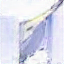

In [552]:
display(gt_img)

### Training Process

In [611]:
from tqdm.notebook import tqdm

In [612]:
import torch.optim as optim

epochs = 10

MAX_LR       = 1e-2
# MAX_LR       = 1e-2
WEIGHT_DECAY = 1e-4
GRAD_CLIP    = 0.1

optimizer = optim.Adam(
    model.parameters(),
    lr=MAX_LR)
    #,weight_decay=WEIGHT_DECAY)

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=epochs, 
#                                                 steps_per_epoch=len(trainloader))

In [613]:
from torch.nn.utils.rnn import pad_sequence

def transform_sample(img, lbl, seq_len=256):
    lbl = TINY_IMAGENET_LABELS[lbl]
    img = img.permute(1, 2, 0)
    out = model.multi_encode(lbl, img, target_image_size=64, original_size=64)
    out = out.squeeze(0)
    padding_len = max(0, seq_len - out.size(0))
    out = F.pad(out, (0, padding_len))
    # print(out.shape)
    return out

def transform_batch(batch):
    imgs, lbls = batch
    lst = [transform_sample(img, lbl)
           for img, lbl in zip(imgs, lbls)]
    out = pad_sequence(lst, batch_first=True, padding_value=0)
    return out

In [ ]:
out = transform_batch(next(iter(trainloader)))

In [680]:
out_s = [multi_decode(out[i].unsqueeze(0)) for i in range(32)]

seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([9]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([6]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([4]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([17]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([9]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([13]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([6]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([14]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([4]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([5]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([5]) torch.Size([16])
seq_s.shape, len(seq): torch.Size([1, 256]) 256
torch.Size([6]) torch.Size([16])
seq_s.shape, len(seq): to

In [697]:
out_lbls = [out_cur[0] for out_cur in out_s]
out_imgs = [out_cur[1] for out_cur in out_s]
out_lbls

['pay-phone',
 'poncho',
 'pole',
 'computer keyboard',
 'trilobite',
 'spiny lobster',
 'mantis',
 'sewing machine',
 'slug',
 'teddy',
 'chain',
 'potpie',
 'jinrikisha',
 'miniskirt',
 'walking stick',
 'tailed frog',
 'abacus',
 'drumstick',
 'bee',
 'teapot',
 'bikini',
 'sulphur butterfly',
 'nail',
 'barbershop',
 'seashore',
 'German shepherd',
 'Arabian camel',
 'jellyfish',
 'picket fence',
 'candle',
 'dam',
 'trilobite']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


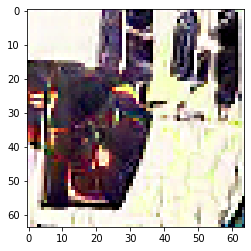

In [700]:
import matplotlib.pyplot as plt
plt.imshow(out_imgs[out_lbls.index("pay-phone")].squeeze(0))

In [627]:
EPOCHS = 1000
PRINT_INTERVAL = 100

def train(model, trainloader):
    model.train()
    batch = out # test_inp # transform_batch(next(iter(trainloader)))
    loss = model(batch, return_loss=True)
    # loss = model(next(trainloader), return_loss=True)
    loss.backward()
    return loss

# pbar = tqdm.tqdm(EPOCHS, mininterval=10., desc='training')
for epoch in range(EPOCHS):
    loss = train(model, trainloader)
    optimizer.step()
    optimizer.zero_grad()
    mem_gb = get_reserved_mem_gb()
    if epoch % PRINT_INTERVAL == 0:
        print(f"Reserved Memory (GB): {mem_gb}, loss: {loss.item()}")
    #' pbar.set_description(f"Reserved Memory (GB): {mem_gb}, loss: {loss.item()}")

Reserved Memory (GB): 3.515625, loss: 13.508164405822754
Reserved Memory (GB): 3.515625, loss: 0.12944212555885315
Reserved Memory (GB): 3.515625, loss: 0.1239478811621666
Reserved Memory (GB): 3.515625, loss: 0.12448947131633759
Reserved Memory (GB): 3.515625, loss: 0.12304460257291794
Reserved Memory (GB): 3.515625, loss: 0.12291009724140167
Reserved Memory (GB): 3.515625, loss: 0.12285818159580231
Reserved Memory (GB): 3.515625, loss: 0.12282339483499527
Reserved Memory (GB): 3.515625, loss: 0.12269654124975204
Reserved Memory (GB): 3.515625, loss: 0.1227508932352066


### Evaluate

In [617]:
# val_img_s, val_cls_s = next(iter(testloader))

In [618]:
# val_cls = TINY_IMAGENET_LABELS[val_cls_s[0]]

In [619]:
# val_cls

'go-kart'

In [705]:
def generate(model, prompt):
    model.eval()

    prompt_enc = torch.tensor(model.text_encode(prompt))
    prompt_enc = prompt_enc.unsqueeze(0).long().to(device)
    print("prompt_enc:", prompt_enc, text_decode(prompt_enc.squeeze(0)))

    sample = model.generate(prompt_enc)
    sample = sample.flatten(1)
    print("sample:", sample, sample.shape)
    prompt, pred_img = multi_decode(sample)
    
    print(prompt)

    return prompt, pred_img

prompt, pred_img = generate(model, "phone")

prompt_enc: tensor([[16640, 16496, 16488, 16495, 16494, 16485, 16641]], device='cuda:0') Āphoneā


100%|██████████| 249/249 [00:01<00:00, 220.05it/s]


sample: tensor([[16640, 16496, 16488, 16495, 16494, 16485, 16641, 16642,  6933,   572,
         11941,  9451, 16248,  3342,  8225,  9035,  9589,  6078,  6882,  3809,
         10019, 11904, 11716,  5522, 16643,  6920, 14473,  7266, 15303, 15936,
         11927,  6756, 16643,  1400,  6522,  7482, 10200,  8612, 12272, 15771,
          4967, 14602,  1270, 13909, 15303,  7800, 16643,  5452,  7191,  5062,
           432, 10278, 11327,  5722, 11574, 11342, 12857, 16643,  2953,  4319,
         16643,   432,  4648,  1597,  5625, 10689,   882,  6948,  2334,  1363,
         11594, 16643,  2469, 15936, 11927,  6756, 16643,  3547,  6172, 13519,
          4319, 16484, 16641, 16642,  4319,  8447, 14703,  9630,  7467, 10689,
         16279,  4075,  2193, 15189, 14839, 16248, 16643, 16505, 16641, 16642,
          4319, 12509,  8225,  9035,  9589,  6078, 11196,  1597, 15771, 14703,
          3742, 15936, 15883,  9157, 15910,  8612,  8431, 15514,  2881,  7504,
         10689,  2193, 15189,  4159, 16643, 

In [706]:
prompt, pred_img

('phone',
 Array([[[[ 0.13666455,  0.12873685,  0.09929268],
          [ 0.14470969,  0.15083732,  0.12151636],
          [ 0.11531761,  0.11031915,  0.09852059],
          ...,
          [ 0.04945007,  0.06627841,  0.07222477],
          [ 0.05520999,  0.07372399,  0.07102969],
          [ 0.06998678,  0.08298163,  0.06809366]],
 
         [[ 0.0940894 ,  0.11342573,  0.08631417],
          [ 0.11023894,  0.10253894,  0.10208048],
          [ 0.09638673,  0.08374429,  0.07432553],
          ...,
          [ 0.03882203,  0.07046581,  0.08210014],
          [ 0.012769  ,  0.06355256,  0.06273156],
          [ 0.03895039,  0.07804771,  0.08819401]],
 
         [[ 0.09677514,  0.12073721,  0.09529233],
          [ 0.0611369 ,  0.06940529,  0.06137119],
          [ 0.08607052,  0.08329381,  0.06468065],
          ...,
          [ 0.02028092,  0.04667149,  0.05183028],
          [ 0.02680061,  0.06042111,  0.049496  ],
          [ 0.02981277,  0.07144746,  0.05506119]],
 
         ...,
 
  

In [707]:
pred_img.shape

(1, 64, 64, 3)

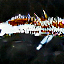

In [708]:
display(pred_img)